# 7. sparkR에서 시각화 실시

In [1]:
Sys.setenv(SPARK_HOME = "C:\\spark-2.4.6-bin-hadoop2.7")
library(SparkR, lib.loc = c(file.path(Sys.getenv("SPARK_HOME"), "R", "lib")))
sparkR.session(master = "local[*]", sparkConfig = list(spark.driver.memory = "4g"))

clusters_data <- read.df("C:\\spark-2.4.6-bin-hadoop2.7\\bin\\Chap5_data\\kddcup.data_10_percent_corrected", "csv",
                         inferSchema = "true", header = "false")
colnames(clusters_data) <- c(
  "duration", "protocol_type", "service", "flag",
  "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
  "hot", "num_failed_logins", "logged_in", "num_compromised",
  "root_shell", "su_attempted", "num_root", "num_file_creations",
  "num_shells", "num_access_files", "num_outbound_cmds",
  "is_host_login", "is_guest_login", "count", "srv_count",
  "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
  "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
  "dst_host_count", "dst_host_srv_count",
  "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
  "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
  "dst_host_serror_rate", "dst_host_srv_serror_rate",
  "dst_host_rerror_rate", "dst_host_srv_rerror_rate",
  "label")


Attaching package: 'SparkR'

The following objects are masked from 'package:stats':

    cov, filter, lag, na.omit, predict, sd, var, window

The following objects are masked from 'package:base':

    as.data.frame, colnames, colnames<-, drop, endsWith, intersect,
    rank, rbind, sample, startsWith, subset, summary, transform, union

Spark package found in SPARK_HOME: C:\spark-2.4.6-bin-hadoop2.7


Launching java with spark-submit command C:\spark-2.4.6-bin-hadoop2.7/bin/spark-submit2.cmd   --driver-memory "4g" sparkr-shell C:\Users\franc\AppData\Local\Temp\RtmpyY46KX\backend_port47646074435d 


Java ref type org.apache.spark.sql.SparkSession id 1 

In [2]:
numeric_only <- cache(drop(clusters_data,
                           c("protocol_type", "service", "flag", "label")))

kmeans_model <- spark.kmeans(numeric_only, ~ .,
                             k = 100, maxIter = 40, initMode = "k-means||")

clustering <- predict(kmeans_model, numeric_only)
clustering_sample <- collect(sample(clustering, FALSE, 0.01))
str(clustering_sample)

'data.frame':	4991 obs. of  39 variables:
 $ duration                   : int  0 0 0 0 0 0 0 0 0 3 ...
 $ src_bytes                  : int  309 155 232 297 152 281 203 202 203 260 ...
 $ dst_bytes                  : int  17798 2026 1302 5246 8159 755 316 259 4584 9743 ...
 $ land                       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ wrong_fragment             : int  0 0 0 0 0 0 0 0 0 0 ...
 $ urgent                     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ hot                        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ num_failed_logins          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ logged_in                  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ num_compromised            : int  0 0 0 0 0 0 0 0 0 0 ...
 $ root_shell                 : int  0 0 0 0 0 0 0 0 0 0 ...
 $ su_attempted               : int  0 0 0 0 0 0 0 0 0 0 ...
 $ num_root                   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ num_file_creations         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ num_shells                 : int  0 0 0 0 0 0 0 0 0 0

In [3]:
clusters=clustering_sample["prediction"]
data=data.matrix(within(clustering_sample,rm("prediction")))

table(clusters)

clusters
   0    2   16   64 
4913    1   17   60 

### 무작위 투영

이 데이터는 38차원이다.
이를 무작위 투영(Random Projection)으로 시각화하려면 3차원 이하의 공간에 투영해야 한다.

In [4]:
#install.packages("rgl")
library(rgl)

#투영 데이터 생성
random_projection = matrix(data=rnorm(3*ncol(data)),ncol=3)

#투영 데이터 정규화
random_projection_norm = random_projection/sqrt(rowSums(random_projection*random_projection))
projected_data = data.frame(data %*% random_projection_norm)

Warning message:
"package 'rgl' was built under R version 3.6.3"

무작위 단위벡터(Unit Vector)를 3개 선택하고, 38차원 데이터를 이 3개의 벡터상으로 투영하여 3차원으로 만든다.

좀 더 정교하게 하기 위해선,
PCA, SVD 등을 이용해서 할 수도 있다.
대신 시간이 오래 걸린다.

In [5]:
num_clusters=max(clusters)
palette = rainbow(num_clusters)
colors = sapply(clusters, function(c) palette[c])
plot3d(projected_data,col=colors, size=100)

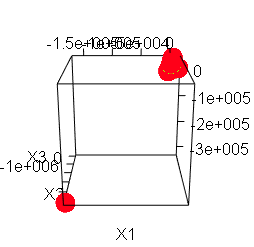

(회전시킬 때 오류가 많이 발생해서 제대로 된 부분은 캡쳐하지 못했다.)